# Advanced Pandas Work

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
fname = "all_res_class_contextvals.csv"
df = pd.read_csv(fname).query("rt < 10")

In [5]:
df.head()

,Unnamed: 0,trial_id,word,correct_key,button,rt,subj,freqs,sims
0,0,0,pinguin,l,l,0.415723,0,2.32,0.000000
1,1,1,goldfisch,l,l,0.487444,0,1.97,0.179393
2,2,2,lama,l,l,0.533625,0,4.09,0.004789
3,3,3,orchidee,l,l,0.470491,0,2.13,0.088054
4,4,4,scotch,l,l,0.459900,0,9.37,0.026734


Statistische Grundfunktionen befinden sich im scipy-Modul `stats`.

In [6]:
from scipy import stats

In [7]:
stats.spearmanr(df["rt"], df["freqs"])

SpearmanrResult(correlation=-0.05419999048463397, pvalue=0.0016126023583921832)

In [8]:
stats.pearsonr(df["rt"], df["freqs"])

(-0.04374412928526735, 0.010940544434177517)

Natürlich lässt sich eine Rangkorrelation auch berechnen, indem man Pandas die Ränge rechnen lässt. Vgl. zur Spearman-Korrelation oben:

In [9]:
stats.pearsonr(df["rt"].rank(), df["freqs"].rank())

(-0.05419999048463397, 0.0016126023583903604)

Oft lohnt es sich, in einem Pandas-Dataframe neue Spalten zu erstellen.

In [10]:
df["rt_ranks"] = df["rt"].rank()
df["iscorrect"] = df["correct_key"] == df["button"]

Damit lassen sich manche Aufgaben schneller erledigen ...

In [11]:
rt_correct = df.query("correct_key == button")["rt"]
rt_incorrect = df.query("correct_key != button")["rt"]
stats.ttest_ind(rt_correct, rt_incorrect)

Ttest_indResult(statistic=6.697868599226574, pvalue=2.4670031451335826e-11)

In [12]:
stats.ttest_ind(df.query("iscorrect")["rt"], df.query("iscorrect == False")["rt"])

Ttest_indResult(statistic=6.697868599226574, pvalue=2.4670031451335826e-11)

Natürlich handelt es sich hier um ein Repeated Measures - Design. Das heißt, wir müssen eigentlich die Daten der einzelnen Versuchspersonen gruppieren.

Wir können das in Pandas mit `df.groupby`:

In [13]:
df.groupby("subj")

Ein `groupby`-Objekt entspricht in etwa einer Liste von Unter-Dataframes. Wir können über sie aggregieren mit Hilfe einer Aggregationsfunktion:

In [14]:
df.query("iscorrect").groupby("subj").mean()["rt"]

subj
0    0.504720
1    0.510656
2    0.457610
3    0.512245
4    0.505778
5    0.646130
6    0.438485
7    0.524098
Name: rt, dtype: float64

Hier haben wir:
    - die richtig beantworteten Trials ausgewählt
    - nach `subj` (Versuchsperson) gruppiert
    - mit dem Mittelwert aggregiert
 
Es ist auch möglich, über mehrere Variablen zu aggregieren:

In [15]:
df.groupby(["subj", "iscorrect"]).mean()["rt"]

subj  iscorrect
0     False        0.494170
      True         0.504720
1     False        0.490985
      True         0.510656
2     False        0.426470
      True         0.457610
3     False        0.475888
      True         0.512245
4     False        0.437818
      True         0.505778
5     False        0.455135
      True         0.646130
6     False        0.416255
      True         0.438485
7     False        0.471623
      True         0.524098
Name: rt, dtype: float64

Das Resultat ist ein *Hierarchischer Index*.  Dieser Mehrebenen-Index kann mit `.reset_index()` in einfache Spalten umgewandelt werden:

In [16]:
df.groupby(["subj", "iscorrect"]).mean()["rt"].reset_index()

,subj,iscorrect,rt
0,0,False,0.494170
1,0,True,0.504720
2,1,False,0.490985
3,1,True,0.510656
4,2,False,0.426470
5,2,True,0.457610
6,3,False,0.475888
7,3,True,0.512245
8,4,False,0.437818
9,4,True,0.505778


Mit `groupby` können wir jetzt einfach die means der einzelnen Versuchspersonen berechnen:

In [17]:
richtige = df.query("iscorrect").groupby("subj")["rt"].mean()
falsche = df.query("iscorrect == False").groupby("subj")["rt"].mean()

stats.ttest_rel(richtige, falsche)

Ttest_relResult(statistic=2.6115258577702902, pvalue=0.0348359204393161)

Wir können auch andere Aggregierungsfunktionen benutzen, zb. die Standardabweichung:

In [18]:
richtige = df.query("iscorrect").groupby("subj")["rt"].std()
falsche = df.query("iscorrect == False").groupby("subj")["rt"].std()

stats.ttest_rel(richtige, falsche)

Ttest_relResult(statistic=0.9300353207986634, pvalue=0.38330547048898866)

Das Resultat von Gruppierung und Aggregierung (sowie evtl. `reset_index()`) ist ein ganz normaler Dataframe:

In [19]:
df.groupby(["subj", "iscorrect"]).mean()["rt"].reset_index().query("iscorrect")

,subj,iscorrect,rt
1,0,True,0.504720
3,1,True,0.510656
5,2,True,0.457610
7,3,True,0.512245
9,4,True,0.505778
11,5,True,0.646130
13,6,True,0.438485
15,7,True,0.524098


Seaborn bietet eine große Spanne von Visualisierungsfunktionen zur Verfügung. Die typische Syntax ist so aufgebaut, dass über die `x`, `y` und `hue` - Variablen angegeben wird, welche Aspekte der Daten - bzw. welche Spalten eines Dataframes (der mit dem `data`-Parameter spezifiziert wird) - auf die X - und Y-Achsen sowie Farbwahl gemappt werden.

/Users/jona/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


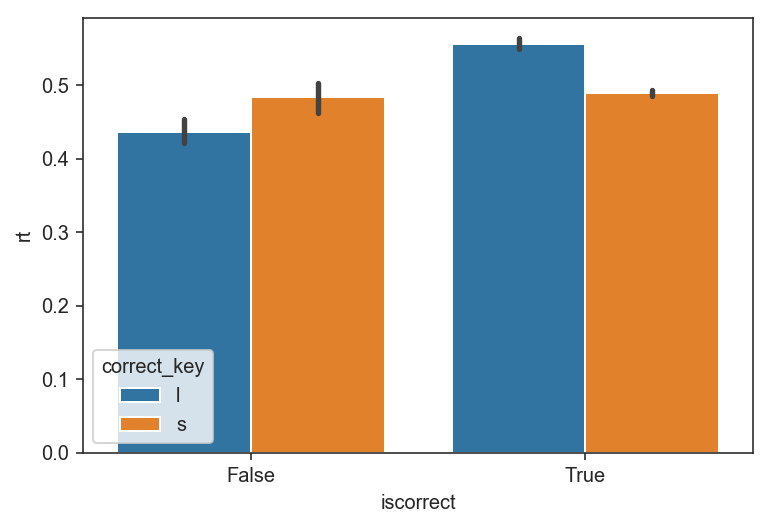

In [20]:
sns.barplot(x="iscorrect", y="rt", hue="correct_key", data=df)

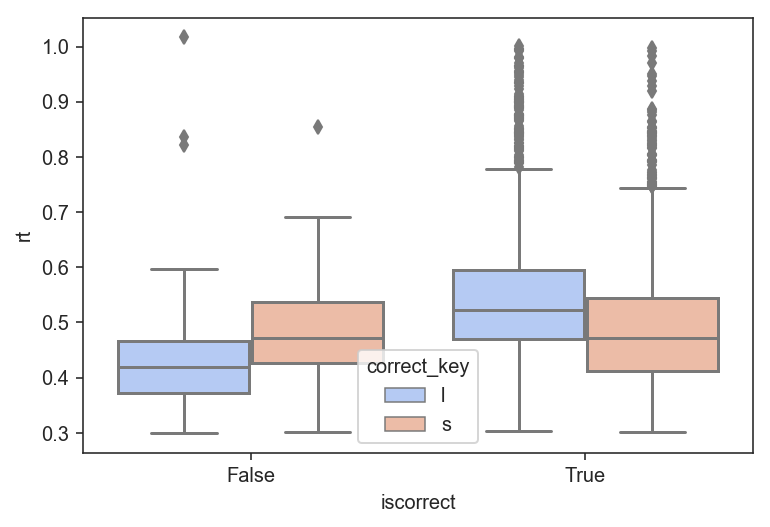

In [21]:
sns.boxplot(x="iscorrect", y="rt", hue="correct_key", data=df, palette="coolwarm")

/Users/jona/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jona/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


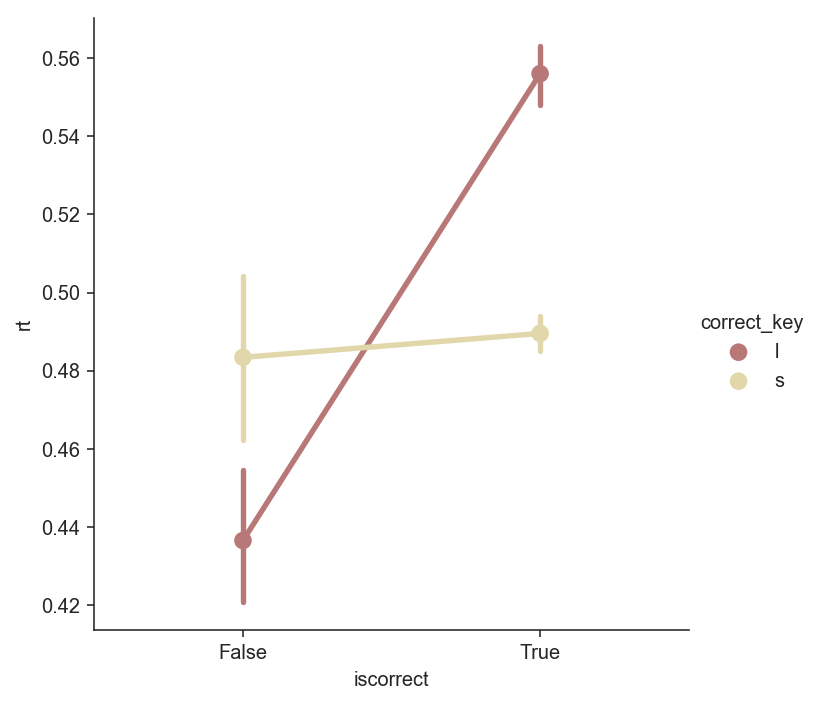

In [22]:
sns.factorplot(x="iscorrect", y="rt", hue="correct_key", data=df, palette="pink")

## Hausaufgabe

- Erstellen Sie einen neuen Dataframe, in dem sie die Daten nach Versuchsperson und der Richtigkeit der Antwort gruppieren. Verwenden Sie `.reset_index()`.

In [ ]:
df_by_subj = df. ...  .reset_index()

- Testen Sie (... mal wieder), ob die durchschnittliche Reaktionszeit für richtig beantwortete Trials pro Versuchsperson sich unterscheidet zwischen richtigen und falschen Antworten. Ziehen sie die Daten dafür aus dem in der vorigen Aufgabe neu erstellen Dataframe.

In [ ]:
correct_rt = df_by_subj[" ... 

...

stats.tt_ ...

* Visualisieren Sie die über VP und Richtigkeit aggregierten Reaktionszeiten mit Hilfe eines Box-, Bar- oder Faktorplots. Verwenden Sie die x-Achse, um die Richtigkeit anzuzeigen.

In [ ]:
sns.factorplot(x=" ..., ", data=df_by_subj ...

### Bonusaufgabe

- Berechnen Sie für jede Versuchsperson einzeln, ob es eine Korrelation zw. Reaktionszeit und Zeit (gemessen als Trialnummer; `trial_id`) gibt. Tipp: DataFrames haben eine `.corr`-Method. Im Zweifelsfalle können Sie folgendermaßen über die Versuchspersonen iterieren:


In [ ]:
for subj in df["subj"].unique():
    df.query("subj == {}".format(subj))
    ...

- Plotten Sie diese Korrelationen mit Hilfe eines Boxplots.
- Berechnen Sie, ob diese Korrelationskoeffizienten sich signifikant von 0 unterscheiden.

* Bonus-Bonusaufgabe: Erledigen Sie Bonusaufgaben 1 + 3 in nur 1 Zeile; verwenden Sie nur innerhalb dieses Notebooks schon verwendete oder zumindest erwähnte Methoden.

In [ ]:
stats.wilcoxon(df.groupby( ...                                                                                                                                                                             df.groupby(["subj"]).corr().reset_index().query("level_1 == 'rt'")["trial_id"]